# Sparsity
In this notebook we will take a look at sparse signals and note some of their properties. We will follow the following notational conventions. We will define a signal, $\mathbf{x} \in \mathbb{R}^N$ to be *sparse* if $K$ elements of $\mathbf{x}$ are non-zero, while the remaining elements are exactly zero. We will define the *sparsity* of $\mathbf{x}$ to be the ratio of the number of non-zeros to zeros,
$$\rho = \frac{K}{N}.$$

Below, we will take a look at a few such signals and study their properties.

In [1]:
# Including Dependencies
%matplotlib inline                  
import numpy as np                  # Numpy, très important
import matplotlib.pyplot as plt     # PyPlot for Plotting
import scipy.fftpack as fftpk       # FFTPack for Harmonic Analy.
from DepsSparsity import *

## Generating Random K-Sparse Signals
---

For now, let us confine ourselves to synthetic examples of exactly $K$-Sparse signals. Let us take a look at how to generate such a signal.

In [2]:
def RandomKSparseSignal(K,N):
    """ Random realization of a K-sparse signal.
    
        Assumes that all non-zero components of the realization
        are drawn iid from a zero-mean Gaussian with a variance 
        of ``1``. 
    
        Input
        ---
        K: int
           Number of non-zeros in the signal.
        N: int
           Signal dimensionality (length)
        
        Returns
        ---
        x: array_like, float
           The K-sparse signal realization, shaped ``(n,1)``
        s: array_like, bool
           The support of ``x``, shaped ``(n,1)``. Has value
           ``True`` at every non-zero location of ``x`` and
           ``False`` everywhere else.
           
        
    """
    x = np.random.randn(N,1)                # Generate iid Gaussian samples     
    s = np.zeros((N,1),dtype=bool)          # Cast ``0.0`` as ``False``
    si = np.random.permutation(N)[1:K]      # Random support locations
    s[si] = True                            # Flag on-support values
    x[np.invert(s)] = 0.0                   # Suppress off-support values of ``x``
    
    return x, s

Now, lets take a look at what what one of these $K$-sparse signals looks like.

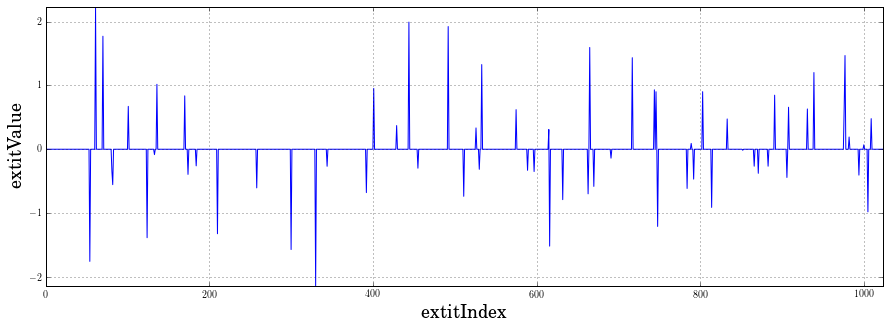

In [3]:
N = 1024         # Desired signal dimensionality
K = 64           # Number of non-zeros
xsparse,xsparse_support = RandomKSparseSignal(K,N)
ShowSignal(xsparse);

In [ ]:
def TopKThreshold(x,K):
    xsorted = sorted(abs(x),reverse=True)
    K = min(K,np.size(x)-2)
    T = xsorted[K+1]
    xT = np.array(x, copy=True)
    xT[abs(xT)<T] = 0.0
    return xT

def MSE(x,y):
    mseval = np.mean(np.power(x-y,2))    
    return mseval

def EnergyRatio(x,y):
    xeng = np.linalg.norm(x,2)
    xeng = xeng*xeng
    
    yeng = np.linalg.norm(y,2)
    yeng = yeng*yeng
    
    return xeng/yeng


    


In [ ]:
def RandomLaplaceSignal(scale,N):
    """ Random realization of a laplace distributed signal.
    """    
    x = np.random.laplace(0.0,scale=scale,size=(N,1))    
    return x

In [ ]:
xlaplace = RandomLaplaceSignal(1.0,1024)
ShowSignal(xlaplace);

In [ ]:
def RandomGaussSignal(sig,N):
    """Random realization of a normally distributed signal."""
    
    x = sig*np.random.randn(N,1)
    return x

In [ ]:
xgauss = RandomGaussSignal(1.0,1024)
ShowSignal(xgauss)

In [ ]:
CompareDecay("K-Spase",xsparse,"Laplace",xlaplace,"Gaussian",xgauss)

In [ ]:
LaplaceERatio = np.zeros((1023,1));
GaussERatio = np.zeros((1023,1));
SparseERatio = np.zeros((1023,1));
LaplaceMSE = np.zeros((1023,1));
GaussMSE = np.zeros((1023,1));
SparseMSE = np.zeros((1023,1));
for k in range(1,1023):
    laplaceK = TopKThreshold(xlaplace,k);
    gaussK = TopKThreshold(xgauss,k);
    sparseK = TopKThreshold(xsparse,k);
    
    LaplaceERatio[k-1] = EnergyRatio(laplaceK,xlaplace)
    GaussERatio[k-1] = EnergyRatio(gaussK,xgauss)
    SparseERatio[k-1] = EnergyRatio(sparseK,xsparse)
    
    LaplaceMSE[k-1] = MSE(laplaceK,xlaplace)
    GaussMSE[k-1] = MSE(gaussK,xgauss)
    SparseMSE[k-1] = MSE(sparseK,xsparse)    

In [ ]:
CompareEnergyCompaction("Sparse",SparseERatio,"Laplace",LaplaceERatio,"Gaussian",GaussERatio);    
CompareMSE("Sparse",SparseMSE,"Laplace",LaplaceMSE,"Gaussian",GaussMSE);    

In [ ]:
plt.plot(xsparse);
plt.plot(fft.ifft(xsparse));

In [ ]:
F = fftpk.fft(xsparse)
plt.plot(F)

In [ ]:
 ?fftpk.fft